In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:

import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob
from pathlib import Path
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torchvision.transforms import v2

from pymono.cnns import x_cnn_evaluation, x_single_run, x_train_cnn
from pymono.cnns import Conv2dPars,  MaxPool2dPars,  LinealLayerPars
from pymono.cnns import build_conv_layer, build_conv_layers, build_linear_layers
from pymono.cnns import xCNN, xResNet10, xResNet8, ResBlock

from pymono.plt_funcs import  plot_loss, plot_accuracy, cifar_plot_image_and_label 
from pymono.plt_funcs import  plot_energies2, histoplot, plotxyz, plot_dataset
from pymono.cnn_plots import plot_images2, plot_images2c
from pymono.cnn_plots import plot2c_z, plot_images_and_labels, plot_images_and_positions

from pymono.cnn_aux import get_file_names_format1, get_image_file_data, get_img_file_metadata
from pymono.cnn_aux import get_energy2, get_means_stds2


from pymono.xdataset import XDataset, RDataset, R2Dataset
from pymono.mono_dl import mono_data_loader
from pymono.cnn_eval import evaluate_cnn, evaluate_2c_cnn, cnn_xeval, single_run, train_cnn

from pymono.cnn_func import CNN_basic
from pymono.cnn_func import  CNN
from pymono.cnn_eval import cnn_evaluation 

from pymono.cnn_fit import fit_coord, fit_tdeltas, plotfxyz



In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Pixelization: xy=6mm z = 12mm

In [4]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")

img_names, csv_name = get_file_names_format1(d1c)

print(f"name of first image file = {img_names[0]}")
print(f"name of label file ={csv_name}")


name of first image file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c/images_1.npy
name of label file =['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c/df1c_xy_6_z_12.csv']


#### Example
- Images and labels in first file of directory

In [5]:
df1c = pd.read_csv(csv_name[0])
df1c.head(10)

,event_id,e,x,y,z,t
0,10004,0.510118,18.645067,12.477487,29.249544,0.116340
1,10006,0.509274,13.566376,1.647984,21.156849,0.090734
2,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
3,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
4,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
5,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
6,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
7,10028,0.509717,9.708068,3.101630,13.316263,0.064982
8,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
9,10030,0.509092,16.716444,15.401320,25.922293,0.107143


In [6]:
imgs, imgf_path, imgf_name, imfn = get_image_file_data(img_names,img_file_index=0)
print(f"image file path = {imgf_path}")
print(f"image file name = {imgf_name}")
print(f"image file number = {imfn}")
print(f"number of images in file = {len(imgs)}")

df1cs = get_img_file_metadata(df1c, imfn)  # This are the events corresponding to the images
print(f"number of labels in file = {len(df1cs)}")

image file path = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_6_z_12/df1c/images_1.npy
image file name = images_1.npy
image file number = 1
number of images in file = 2605
number of labels in file = 2605


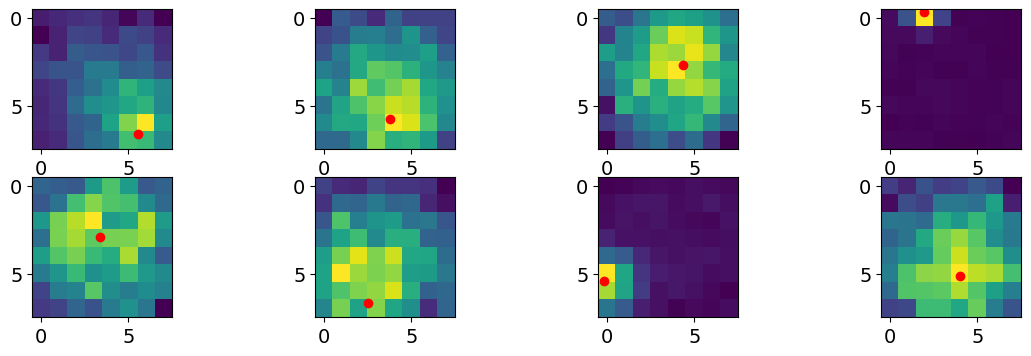

In [7]:
plot_images2(imgs, df1cs, (0,8), pixel_size = 6, grid_size=8)

In [8]:
energy = get_energy2(imgs)

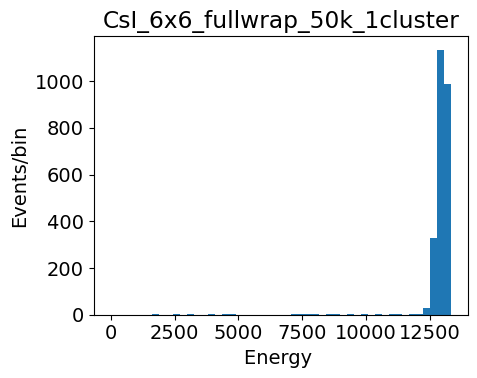

In [9]:
plot_energies2({"CsI_6x6_fullwrap_50k_1cluster":energy}, xmin=0, xmax=max(energy),num_bins = 50)

### Load data
- Use RDataset which stores (images, (x,y,z)).
- No normalization.
- No previous classification

In [10]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 200  # Batch size
train_fraction=0.7 
val_fraction=0.2

## 1c

In [11]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=False)  

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 100
   event_id         e          x          y          z         t
0     10004  0.510118  18.645067  12.477487  29.249544  0.116340
1     10006  0.509274  13.566376   1.647984  21.156849  0.090734
2     10014  0.509922  -5.014233   5.060986  12.715019  0.062352
3     10018  0.508170 -22.957691  -9.322307  45.483715  0.171746
4     10024  0.508948  -3.514938  -0.639491  15.746504  0.074194
5     10026  0.508879  18.973616  -6.031100  16.421364  0.074508
6     10027  0.508849  11.437413 -22.155209  40.912632  0.157729
7     10028  0.509717   9.708068   3.101630  13.316263  0.064982
8     10029  0.509517   0.335767 -11.193620  21.898740  0.093051
9     10030  0.509092  16.716444  15.401320  25.922293  0.107143
image name = images_1.npy
image number = 1
number of images in file = 2605
number of labels in file = 2605
meta =>[1.00040000e+04 5.10118200e-01 1.86450670e+01 1.24774870e+01
 2.92495440e+01 1.16340

In [12]:
dataset[3]

(tensor([[[ 179.,  718., 2478.,  585.,  124.,  140.,  127.,  117.],
          [ 172.,  173.,  314.,  170.,  149.,  129.,  131.,  121.],
          [ 161.,  127.,  136.,  149.,  149.,  152.,  114.,  120.],
          [ 148.,  141.,  153.,  124.,  129.,  150.,  130.,  128.],
          [ 130.,  132.,  163.,  169.,  143.,  138.,  138.,  143.],
          [ 162.,  154.,  148.,  162.,  152.,  137.,  136.,  144.],
          [ 123.,  140.,  124.,  153.,  138.,  141.,  144.,  133.],
          [ 146.,  147.,  160.,  127.,  129.,  123.,  134.,  142.]]]),
 tensor([-22.9577,  -9.3223,  45.4837]))

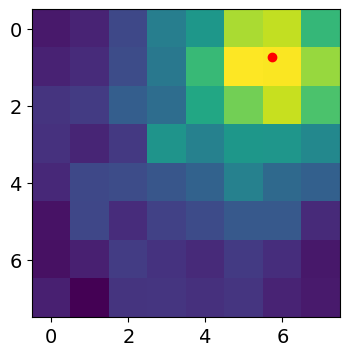

In [13]:
plot_dataset(dataset[15], pixel_size = 6, grid_size=8)

In [14]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 259889 events
 train size = 181922
 val size = 51977
 test size = 25990
 train indices = range(0, 181922)
 val indices = range(181922, 233899)
 test indices = range(233899, 259889)
181922 training events (69.99988456610322%)
51977 validation events (19.999692176275257%)
25990 test events (10.000423257621524%)


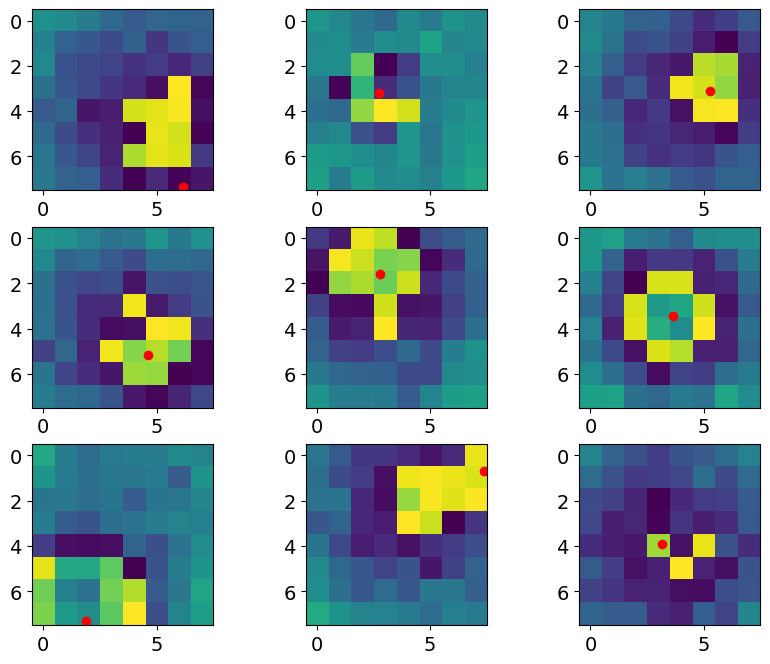

In [15]:
plot_images_and_positions(train_loader, start=0, figsize=(10, 8))

In [16]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [18]:
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->182000 images
size of train loader  ->910 images
Evaluating with  ->52000 images
size of eval loader  ->260 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([200, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([200, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([200, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([200, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([200, 512])
torch.Size([200, 3])
--- EPOCH 0 AVG TRAIN LOSS: 12.084949672091138
--- EPOCH 0 AVG VAL LOSS: 8.547698972775386

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.944075429308546
--- EPOCH 1 AVG VAL LOSS: 7.4316883288897

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.303707755266965
--- EPOCH 2 AVG VAL LOSS: 8.669505167007447

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 6.933489565272907
--- EPOCH 3 AVG VAL LOSS: 7.270368374311007

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.618699469933143
--- EPOCH 4 AVG VAL LOSS: 6.25069860128256

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.4285158063029195
--- EPOCH 5 AVG VAL LO

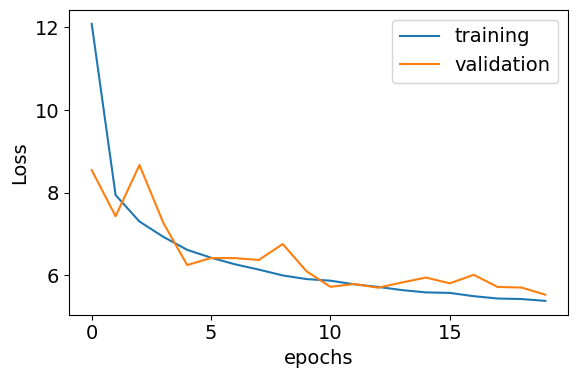

In [19]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

In [20]:
tdeltas = evaluate_cnn(test_loader, model, device)

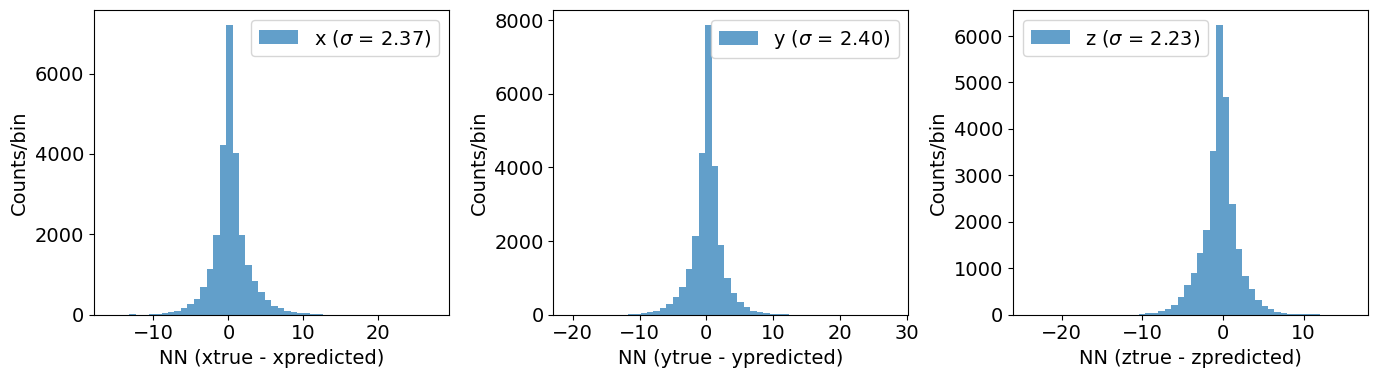

In [21]:
plotxyz(tdeltas, nbins=50)

In [22]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = -0.41, sigma = 2.52, n1  =0.32
2g fit: mu2 = -0.25, sigma = 0.66, n1  =0.68
weighted error: = 1.26
2g fit: mu1 = 0.22, sigma = 2.45, n1  =0.30
2g fit: mu2 = 0.08, sigma = 0.62, n1  =0.70
weighted error: = 1.17
2g fit: mu1 = 0.25, sigma = 0.61, n1  =0.67
2g fit: mu2 = 0.10, sigma = 2.35, n1  =0.33
weighted error: = 1.18


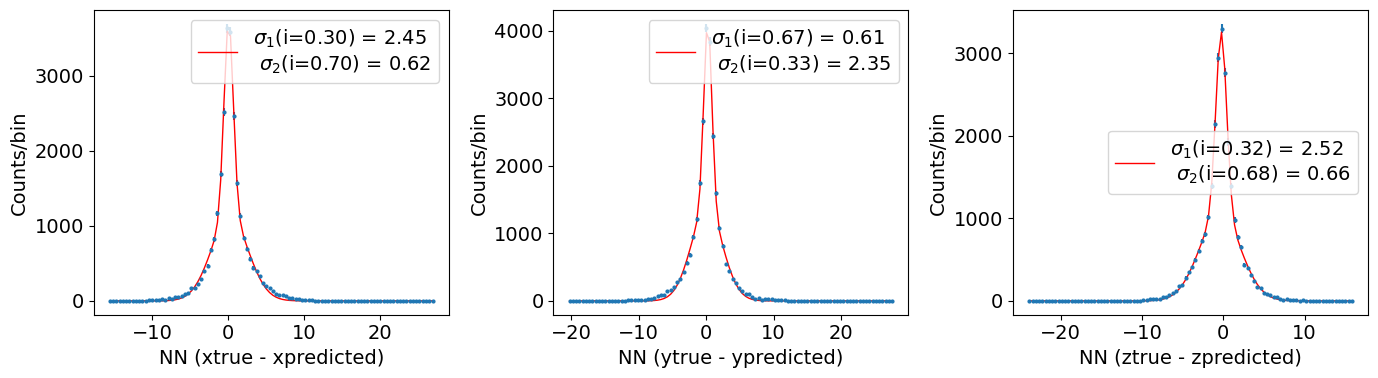

In [23]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))

## XY=12 mm, Z = 12 mm

In [24]:
data_dir = Path(os.environ['MONOLITH_DATA'])
dir_root = os.path.join(data_dir,"CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_12_z_12")
d1c = os.path.join(dir_root,"df1c")
d2c = os.path.join(dir_root,"df2c")

img_names, csv_name = get_file_names_format1(d1c)

print(f"name of first image file = {img_names[0]}")
print(f"name of label file ={csv_name}")

name of first image file = /home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_12_z_12/df1c/images_1.npy
name of label file =['/home/investigator/Data/monolithic_csi/CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_gamma_vox_xy_12_z_12/df1c/df1c_xy_12_z_12.csv']


In [25]:
df1c = pd.read_csv(csv_name[0])
df1c.head(10)

,event_id,e,x,y,z,t
0,10004,0.510118,18.645067,12.477487,29.249544,0.116340
1,10006,0.509274,13.566376,1.647984,21.156849,0.090734
2,10014,0.509922,-5.014233,5.060986,12.715019,0.062352
3,10018,0.508170,-22.957691,-9.322307,45.483715,0.171746
4,10024,0.508948,-3.514938,-0.639491,15.746504,0.074194
5,10026,0.508879,18.973616,-6.031100,16.421364,0.074508
6,10027,0.508849,11.437413,-22.155209,40.912632,0.157729
7,10028,0.509717,9.708068,3.101630,13.316263,0.064982
8,10029,0.509517,0.335767,-11.193620,21.898740,0.093051
9,10030,0.509092,16.716444,15.401320,25.922293,0.107143


In [26]:
dataset = RDataset(dir_root, first_file, last_file,type="1c", norm=False)  

Running rDataset with norm = False
Loading files in directory d1c with indexes: 0, 100
   event_id         e          x          y          z         t
0     10004  0.510118  18.645067  12.477487  29.249544  0.116340
1     10006  0.509274  13.566376   1.647984  21.156849  0.090734
2     10014  0.509922  -5.014233   5.060986  12.715019  0.062352
3     10018  0.508170 -22.957691  -9.322307  45.483715  0.171746
4     10024  0.508948  -3.514938  -0.639491  15.746504  0.074194
5     10026  0.508879  18.973616  -6.031100  16.421364  0.074508
6     10027  0.508849  11.437413 -22.155209  40.912632  0.157729
7     10028  0.509717   9.708068   3.101630  13.316263  0.064982
8     10029  0.509517   0.335767 -11.193620  21.898740  0.093051
9     10030  0.509092  16.716444  15.401320  25.922293  0.107143
image name = images_1.npy
image number = 1
number of images in file = 3032
number of labels in file = 3032
meta =>[1.00040000e+04 5.10118200e-01 1.86450670e+01 1.24774870e+01
 2.92495440e+01 1.16340

In [27]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 305080 events
 train size = 213556
 val size = 61016
 test size = 30508
 train indices = range(0, 213556)
 val indices = range(213556, 274572)
 test indices = range(274572, 305080)
213556 training events (70.0%)
61016 validation events (20.0%)
30508 test events (10.0%)


In [28]:
model = CNN_basic(chi=128, dropout=False, dropout_fraction=0.2, energy=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_losses, val_losses = train_cnn(train_loader, val_loader, model, optimizer, device, criterion, 
                                     batch_size, epochs=20, iprnt=100)

Training with  ->213600 images
size of train loader  ->1068 images
Evaluating with  ->61200 images
size of eval loader  ->306 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([200, 1, 8, 8])
(8,8,1) => (4,4,128) =>torch.Size([200, 128, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([200, 256, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([200, 512, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([200, 512])
torch.Size([200, 3])
--- EPOCH 0 AVG TRAIN LOSS: 11.325876615020666
--- EPOCH 0 AVG VAL LOSS: 9.211054993610755

EPOCH 1
--- EPOCH 1 AVG TRAIN LOSS: 7.999919479259391
--- EPOCH 1 AVG VAL LOSS: 7.201677574830897

EPOCH 2
--- EPOCH 2 AVG TRAIN LOSS: 7.411263576161103
--- EPOCH 2 AVG VAL LOSS: 7.620709275887682

EPOCH 3
--- EPOCH 3 AVG TRAIN LOSS: 7.024711685680718
--- EPOCH 3 AVG VAL LOSS: 7.288318962832681

EPOCH 4
--- EPOCH 4 AVG TRAIN LOSS: 6.8204068945588245
--- EPOCH 4 AVG VAL LOSS: 7.0823151504292206

EPOCH 5
--- EPOCH 5 AVG TRAIN LOSS: 6.662369463774149
--- EPOCH 5 AVG V

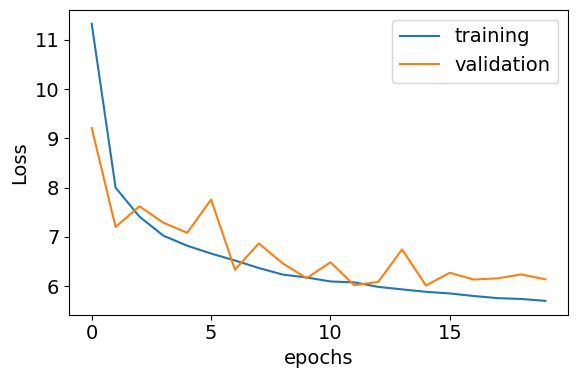

In [29]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))

In [30]:
tdeltas = evaluate_cnn(test_loader, model, device)

In [31]:
f2gz, f2gx, f2gy = fit_tdeltas(tdeltas, bins=100)

2g fit: mu1 = -0.03, sigma = 2.67, n1  =0.35
2g fit: mu2 = 0.39, sigma = 0.67, n1  =0.65
weighted error: = 1.36
2g fit: mu1 = 0.09, sigma = 0.71, n1  =0.60
2g fit: mu2 = -0.43, sigma = 2.39, n1  =0.40
weighted error: = 1.39
2g fit: mu1 = -0.14, sigma = 2.49, n1  =0.34
2g fit: mu2 = -0.18, sigma = 0.64, n1  =0.66
weighted error: = 1.27


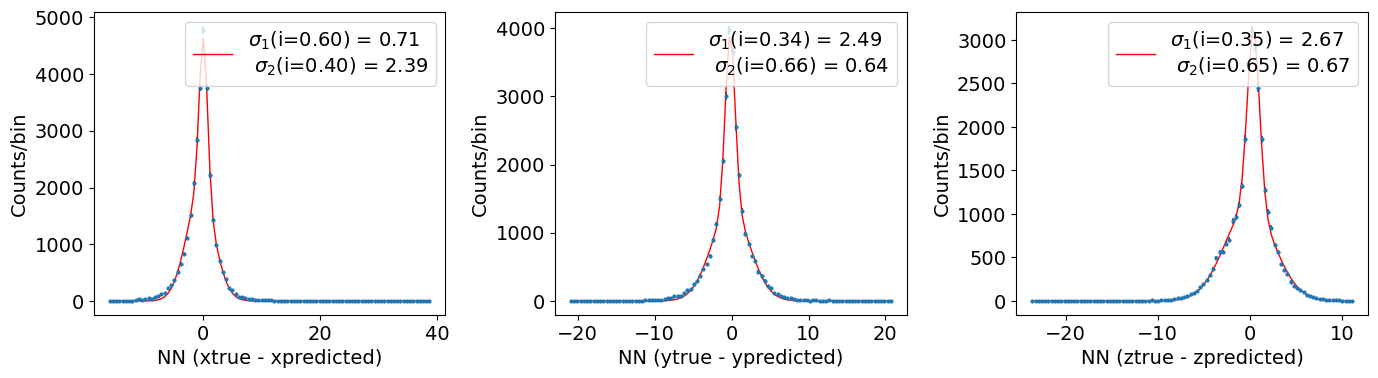

In [32]:
plotfxyz(f2gx, f2gy, f2gz, figsize=(14, 4))